In [1]:
from cProfile import label
import time
import argparse
from xmlrpc.client import boolean
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

import torch
import torch.nn.functional as F
import torch.optim as optimize 
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
from util.func import csv2numpy
import glob

import matplotlib.pyplot as plt
from PIL import Image
import cv2
from util.dataloader import IRT, IRTHybrid
from torch.utils.data import DataLoader
from models.CNN import AlexNet, EfficientNet

# Image / IRT Data

### Setup

In [2]:
test = 1
speed = '20Hz'
direc = 'lateral'
img_list = sorted(glob.glob(os.path.join('data', str(test), speed, 'images', '*.png'), recursive=True))
irt_list = sorted(glob.glob(os.path.join('data', str(test), speed, 'thermal_mat', '*.csv'), recursive=True))

len(irt_list), len(img_list)

# plt.imshow(cv2.imread(img_list[10]))

(43, 43)

In [3]:
df_img = pd.read_csv('thermal_img.csv', index_col=0).sort_values(by = ['path'])
df_irt = pd.read_csv('thermal_mat.csv', index_col=0)
df_img.tail()
# df_irt.tail()

,path,category,label
2076,data/3/60Hz/images/R20211117_3735.png,S3,3
2179,data/3/60Hz/images/R20211117_3736.png,S3,3
1971,data/3/60Hz/images/R20211117_3737.png,S3,3
2260,data/3/60Hz/images/R20211117_3738.png,S3,3
2201,data/3/60Hz/images/R20211117_3739.png,S3,3


(480, 640, 3)
(921600,)


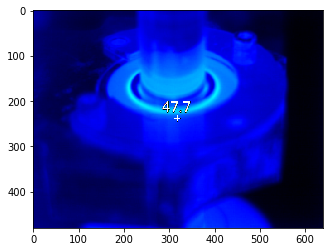

In [4]:
img = cv2.imread(df_img['path'][590])
# img = csv2numpy(df_irt['path'][590])
original_size = img.shape
print(img.shape)
# plt.imshow(img)
# plt.show()
img = img.flatten()
print(img.shape)
img = np.resize(img, original_size)
plt.imshow(img)

In [8]:
class args: pass
args.cuda = True
args.device = 1
args.epochs = 1
args.batchSize = 5
args.dataAugmentation =False
args.log_interval=100
args.lr = 1e-4
args.momentum = 0.9
args.dtype = 'img'
args.seed = 1

In [9]:
dtype = 'img'

if dtype == 'img':
    x_train, x_test, y_train, y_test = train_test_split(df_img['path'].values, df_img['label'].values,
                                                            test_size=0.3,
                                                            random_state=1234,
                                                            stratify=df_img['label'].values)
elif dtype == 'irt':
    x_train, x_test, y_train, y_test = train_test_split(df_irt['path'].values, df_irt['label'].values,
                                                            test_size=0.3,
                                                            random_state=1234,
                                                            stratify=df_irt['label'].values)

### Model

In [10]:
class AlexNet_(nn.Module):
    
    def __init__(self, dtype):
        super(AlexNet_, self).__init__()

        ##Combinada
        if dtype == 'img':
            self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 9, stride=2, padding=0 ) 
            self.batchNorm1 = nn.BatchNorm2d(num_features=96), 
            self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) 
            self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 4)
            self.weight2 = self.conv2.weight.data.numpy()

            self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1) 
            self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1) 
            self.fc1  = nn.Linear(in_features= 3456, out_features= 2304)
            self.fc2  = nn.Linear(in_features= 2304, out_features= 4096)
            self.fc3  = nn.Linear(in_features= 4096, out_features= 4096)
            self.fc4 = nn.Linear(in_features=4096 , out_features=4)
        elif dtype == 'hybrid':
            self.conv1 = nn.Conv2d(in_channels=4, out_channels= 96, kernel_size= 9, stride=2, padding=0 ) 
            self.batchNorm1 = nn.BatchNorm2d(num_features=96), 
            self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) 
            self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 4)
            self.weight2 = self.conv2.weight.data.numpy()

            self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1) 
            self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1) 
            self.fc1  = nn.Linear(in_features= 3456, out_features= 2304)
            self.fc2  = nn.Linear(in_features= 2304, out_features= 4096)
            self.fc3  = nn.Linear(in_features= 4096, out_features= 4096)
            self.fc4 = nn.Linear(in_features=4096 , out_features=4)
        elif dtype == 'irt':
            print('using irt_mat data')
            self.conv1 = nn.Conv2d(in_channels=1, out_channels= 96, kernel_size= 9, stride=2, padding=0 ) 
            self.batchNorm1 = nn.BatchNorm2d(num_features=96), 
            self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) 
            self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 4)
            self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1) 
            self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1) 
            self.fc1  = nn.Linear(in_features= 3456, out_features= 2304)
            self.fc2  = nn.Linear(in_features= 2304, out_features= 4096)
            self.fc3  = nn.Linear(in_features= 4096, out_features= 4096)
            self.fc4 = nn.Linear(in_features=4096 , out_features=4)

    def forward(self,img, irt=None):
        # img = 
        x = F.relu(self.conv1(img)) # out_dim [110x110x96]
        x = self.maxpool(x) # out_dim [55x55x96]
        x = F.relu(self.conv2(x))  # out_dim [29x29x256]
        x = self.maxpool(x)  # out_dim [14x14x256]
        # plt.imshow(self.weight2[0, 2])
        # plt.show()
        x = F.relu(self.conv3(x)) # out_dim [14x14x384]
        x = self.maxpool(x)  # out_dim [7x7x256]
        x = F.relu(self.conv4(x)) # out_dim [8x8x384]
        x = self.maxpool(x)  # out_dim [4x4x256]
        x = self.maxpool(x)  # out_dim [6x6x256]
        x = x.reshape(x.shape[0], -1)  # out_dim [9216x1]
        x = F.relu(self.fc1(x)) # out_dim [4096x1]
        x = F.relu(self.fc2(x)) # out_dim [4096x1]
        x = F.relu(self.fc3(x)) # out_dim [4096x1]
        x = self.fc4(x) # out_dim [1000x1]

        return x

### DataLoader

In [13]:
import os
#from skimage import io, transform
import cv2 as cv
from numpy import dtype

import torch
from torch.utils.data import Dataset
from util.func import csv2numpy
import numpy as np


# Dataset class
class IRT_(Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, images_paths, labels, data_path, dtype = 'img', transform=None):
        super(IRT_, self).__init__()
        'Initialization'
        self.labels = labels
        self.images_paths = images_paths
        self.transform = transform
        self.data_path = data_path
        self.dtype = dtype

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.images_paths)

  def __getitem__(self, index):
        if self.dtype == 'irt':
            'Generates one sample of data'
            #   print(self.images_paths[index])
            path = self.images_paths[index]
            
            # Load data and get label
            label = self.labels[index]
            image = csv2numpy(path)
            print(image.shape)
            image= np.array([cv.resize(image, (227,227), interpolation=cv.INTER_CUBIC)])  #W,H,C   [200, 300, 3]
            # image = image.transpose(2, 0, 1) #C,W,H  [3,200,300]

            if self.transform:
                  image = self.transform(image)
            return image, label
        elif self.dtype == 'img':
            'Generates one sample of data'
            #   print(self.images_paths[index])
            path = self.images_paths[index]
            
            # Load data and get label
            label = self.labels[index]
            image = cv.imread(path, cv.IMREAD_COLOR)
            if image.shape == (640, 480, 3):
                  image = np.rot90(image)
            #   print(image.shape)
            # image= cv.resize(image, (227,227), interpolation=cv.INTER_CUBIC)  #W,H,C   [200, 300, 3]
            image = image.transpose(2, 0, 1) #C,W,H  [3,200,300]

            if self.transform:
                  image = self.transform(image)
            return image, label
        
data_path = '/home/edgomez10/Project/TB-and-IB-analysis-of-IRT-for-the-state-assessment-of-rolling-bearings-using-DL/data'
train_set = IRT_(x_train, y_train, data_path=data_path, transform=None, dtype = 'img')
train_loader = DataLoader(train_set, batch_size=5, shuffle=True)

In [14]:
type(train_set.__getitem__(0)[0])

numpy.ndarray

In [18]:
data = next(iter(train_loader))
print('mean',torch.Tensor.float(data[0]).mean())
print('std',torch.Tensor.float(data[0]).std())
print('std',torch.Tensor.float(data[0]).shape)


mean tensor(44.1772)
std tensor(76.7646)
std torch.Size([5, 3, 480, 640])


### Training

In [19]:
model = AlexNet_(dtype='img')
model.cuda(args.device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optimize.Adam(model.parameters(), lr = args.lr)
train_loss = 0
for batch_idx, (data, target) in enumerate(train_loader):
    if args.cuda:
        data, target = data.cuda(args.device), target.cuda(args.device)
    data, target = Variable(data), Variable(target)
    print('data shape: ', data.shape)
    print('target: ', target.shape)
    data = data.float()
    optimizer.zero_grad()

    scores = model(data)
    loss = criterion(scores, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    if batch_idx % args.log_interval == 0:
        print(f'Batch: {batch_idx} --> Loss: {loss}')

torch.save(model.state_dict(), '%s/%s' % (args.bestmodel_path,args.save))
    


data shape:  torch.Size([5, 3, 480, 640])
target:  torch.Size([5])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (5x26880 and 3456x2304)

: 